In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
#!pip install easydev                 #version 0.12.0
#!pip install colormap                #version 1.0.4
#!pip install opencv-python           #version 4.5.5.64
#!pip install colorgram.py            #version 1.2.0
#!pip install extcolors               #version 1.0.0
#!pip install webcolors               #version 1.0.0

import cv2
import extcolors

from colormap import rgb2hex

from webcolors import rgb_to_name

### Color extraction
https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e

Extract color with the extcolors library. The parameters that we have to set up:

* tolerance: group colors to limit the output and give a better visual representation. Based on a scale from 0 to 100. Where 0 won’t group any color and 100 will group all colors into one.
* limit: upper limit to the number of extracted colors presented in the output.

#### funcion a eliminar
_____

def color_to_df_old(input): #added also de rgb codification
    
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up,df_rgb, df_percent), columns = ['c_code','rgb','occurence'])
    return df
def rgb2hex_local(r,g,b): return rgb2hex(r,g,b)

In [3]:
from webcolors import CSS3_HEX_TO_NAMES, hex_to_rgb,rgb_to_name

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return '~'+ min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        color_name = rgb_to_name(requested_colour)
    except ValueError:
        color_name = closest_colour(requested_colour)
        
    return color_name

In [4]:
#https://medium.com/codex/rgb-to-color-names-in-python-the-robust-way-ec4a9d97a01f
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)
def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index] #f'closest match: {names[index]}'

In [5]:

def color_to_df(input): #added also de rgb codification
    
    input_unzip = list(zip(*input[0]))
    ar_rgbs=np.array([np.array(item) for item in input_unzip[0]])
    rgbs=pd.DataFrame(ar_rgbs, columns=['R','G','B'])
    ncounts=pd.DataFrame(input_unzip[1], columns=['occurence'])

    df=pd.concat([rgbs,ncounts], axis=1)
    df['c_code']= df.apply(lambda df: rgb2hex(df.R,df.G,df.B), axis=1) 
    df['c_name']= df.apply(lambda df: get_colour_name((df.R,df.G,df.B)), axis=1) 

    return df

def exact_color(input_path,input_image, resize, tolerance, zoom,ncolors):
    
    #background template
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)    
    
    #resize -limitation in order to control de output and limit the time of process
    img = Image.open(input_path+input_image)   
    print('Original image size (W,H): (',img.size[0],img.size[1],').')
    
    if img.mode in ("RGBA", "P"): img = img.convert("RGB") #added to avoid errors from diferent inputs
        
    output_width =  resize
    
    if img.size[0] != resize: # resize to all pictures, even smaller, for a nice-ouput
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        #print(type(output_width), type(hsize),output_width,hsize)
        img = img.resize((output_width,hsize),  Image.Resampling.LANCZOS)
               
        resize_name = 'resize_'+ input_image
        img.save(input_path+resize_name)
    else:
        resize_name = input_image
    
    #create dataframe
    img_url = input_path + resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance , limit = ncolors)
    
    
    df_color = color_to_df(colors_x)
    
    #annotate text, filtering the data to show in the palette
    df_color_complete=df_color.copy()  
    df_color=df_color.sort_values(by=['occurence'], ascending=False).head(24) #maximum 4 columns of 6 colors to show
    
    #df.color
    #df_color=df_color_complete[df_color_complete.occurence >round((img.size[0]*img.size[1])*0.001)]
    #df_color.head()
       
    
    
    print('Image resize (W,H): (',img.size[0],img.size[1],').')
    # selimita a los 24 colores mas representativos.' Minimum dots:',round((img.size[0]*img.size[1])*0.001))
    
    list_color = list(df_color['c_code'])
    list_colorName = list(df_color['c_name'])
    list_percent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + '  ' + str(round(p*100/sum(list_percent),1)) +'%' for c, p in zip(list_color, list_percent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_percent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 120, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(input_path + resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2,y_posi3  = 160, -130, -130,-130
    
    for  n,c in enumerate(list_color):
        if list_color.index(c) <= 7:
            y_posi += 130
            rect = patches.Rectangle((x_posi, y_posi), 100, 75, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+100, y = y_posi+50, s = list_colorName[n], fontdict={'fontsize': 120})
            
        elif list_color.index(c) <= 15:
            y_posi2 += 130
            rect = patches.Rectangle((x_posi + 600, y_posi2), 100, 75, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+700, y = y_posi2+50, s = list_colorName[n], fontdict={'fontsize': 120})             
            
        else:
            y_posi3 += 130
            rect = patches.Rectangle((x_posi + 600*2, y_posi3), 100, 75, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1300, y = y_posi3+50, s = list_colorName[n], fontdict={'fontsize': 120})
            
           

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    plt.show()
    return df_color_complete

In [6]:
#path_bs='./data/'
#nameInFile="AH06.jpg"
#path_bs='./data/DH/'
#nameInFile="DH02.jpg"

#print(path_bs + nameInFile)

#df_colours=exact_color(path_bs,nameInFile, 900, 18, 2.5,100)#ncolors=12,aumentado a 18


#para añadir el nombre a los colores
#https://matplotlib.org/stable/tutorials/colors/colors.html

pd.set_option('display.max_rows', 100)
df_colours



image=Image.open('./data/DH/' + "DH02.jpg")
image = np.asarray(image)

#extract all rgb unique values from the pisture with the numbre of ocurrences
aa=np.unique(image.reshape(-1, image.shape[2]),
        axis=0,return_counts =True)
aa0=pd.DataFrame(aa[0], columns=['R','G','B'])
aa1=pd.DataFrame(aa[1], columns=['Ncounts'])
aa= pd.concat([aa0,aa1], axis=1)



pd.set_option('display.max_rows', 50)
aa.sort_values(by=['Ncounts'], ascending=False)


len(CSS3_HEX_TO_NAMES)

rgb_to_name?

from matplotlib import colors
len(colors.cnames)

./data/DH/DH03.jpg
Original image size (W,H): ( 276 183 ).
Image resize (W,H): ( 900 596 ).


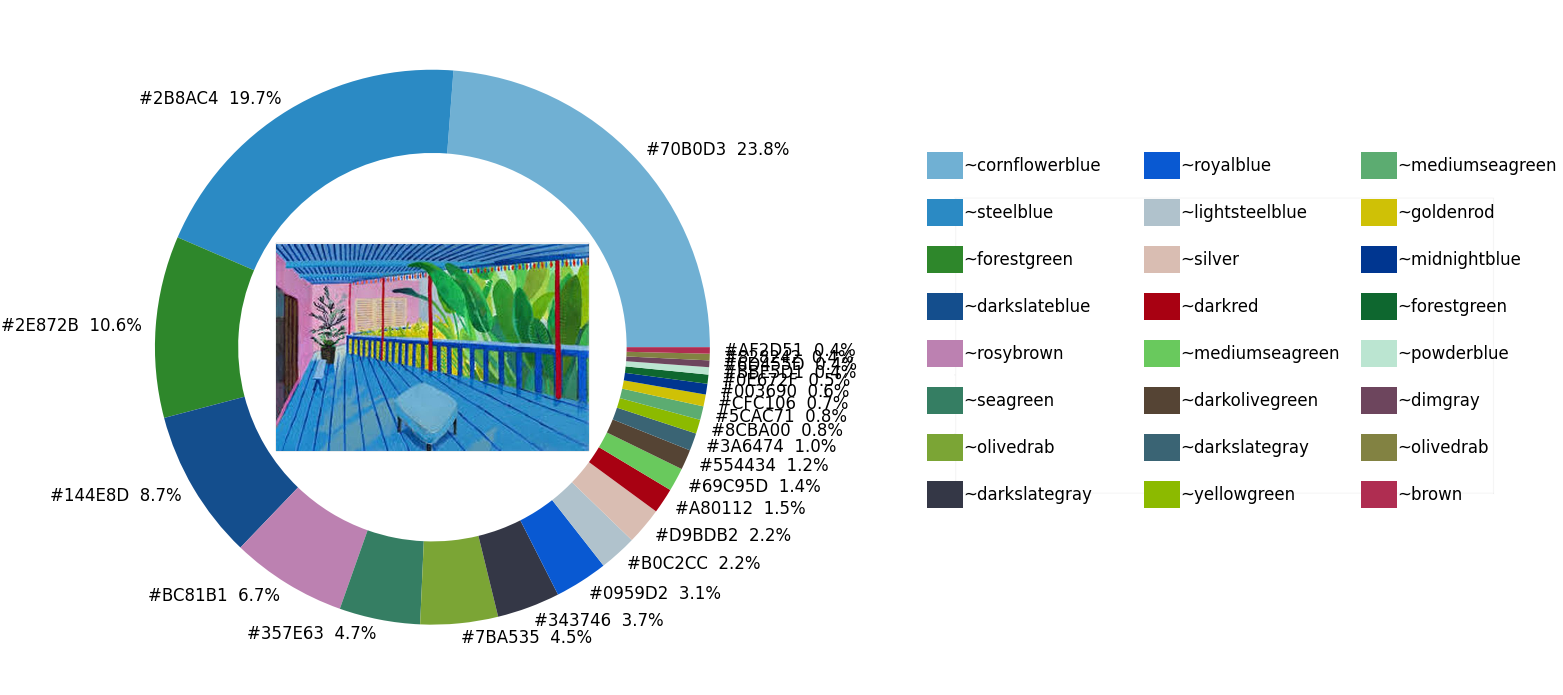

In [7]:
path_bs='./data/'
nameInFile="AH01.jpg"
path_bs='./data/DH/'
nameInFile="DH03.jpg"

print(path_bs + nameInFile)

df_colours=exact_color(path_bs,nameInFile, 900, 20, 2.5,500)#ncolors=12,aumentado a 24 para mostrar. en el df recoge todos los colores

df_colours.to_csv('./data/tmp/tmp_df_colours.csv')

#para añadir el nombre a los colores
#https://matplotlib.org/stable/tutorials/colors/colors.html

In [20]:
df_colours.head()

,R,G,B,occurence,c_code,c_name
0,112,176,211,124137,#70B0D3,~cornflowerblue
1,43,138,196,102967,#2B8AC4,~steelblue
2,46,135,43,55224,#2E872B,~forestgreen
3,20,78,141,45590,#144E8D,~darkslateblue
4,188,129,177,35202,#BC81B1,~rosybrown


In [21]:
print(sum(df_colours.occurence))
900*596

536400


536400

In [22]:
path_bs + nameInFile

'./data/DH/DH03.jpg'

In [23]:
pd.set_option('display.max_rows', 300)

df_colours
#pd.set_option('display.max_rows', 50)





,R,G,B,occurence,c_code,c_name
0,112,176,211,124137,#70B0D3,~cornflowerblue
1,43,138,196,102967,#2B8AC4,~steelblue
2,46,135,43,55224,#2E872B,~forestgreen
3,20,78,141,45590,#144E8D,~darkslateblue
4,188,129,177,35202,#BC81B1,~rosybrown
5,53,126,99,24569,#357E63,~seagreen
6,123,165,53,23552,#7BA535,~olivedrab
7,52,55,70,19142,#343746,~darkslategray
8,9,89,210,16172,#0959D2,~royalblue
9,176,194,204,11398,#B0C2CC,~lightsteelblue


pandas.core.frame.DataFrame